## Import and define

In [ ]:
from near_dedup import *
rdp = SparkDataProcessor()
spark=rdp.spark  

## Configurate DIR

In [ ]:
data_files = get_data_files('/home/vmagent/app/test_data/')
dup_dir = "/home/vmagent/app/test_data/deduplicate"
ngram_size = 6
num_perm = 256
threshold = 0.7
bands = 9
ranges = 13

## Load data into Spark

In [ ]:
with Timer("Load data with RowID"):
    df = read_json(data_files, spark).cache()
    total_length = df.count()

## Get minHashLSH edges

In [ ]:
pipeline = minHashLSH_prepare(df, num_perm, ngram_size, bands, ranges)
with Timer("generate minHashLsh"):
    if os.path.exists(dup_dir):
        shutil.rmtree(dup_dir, ignore_errors=True)
    results = pipeline.saveAsTextFile(dup_dir)

## Generate connected components

In [ ]:
with Timer(f"generate_connected_components all"):
    dup_connected_args = argparse.Namespace()
    dup_connected_args.input_dir = dup_dir
    dup_connected_args.out_file = os.path.join(
        dup_dir, "connected_components.pickle"
    )
    generate_connected_components.generate_connected_components_mp(dup_connected_args)

##  convert as duplicates dict

In [ ]:
with Timer(f"generate_duplicates_dict all"):
    dup_docs = os.path.join(dup_dir, "duplicates.pickle")
    dup_dict_args = argparse.Namespace()
    dup_dict_args.input_file = os.path.join(
        dup_dir, "connected_components.pickle"
    )
    dup_dict_args.out_file = dup_docs
    generate_duplicates_dict.generate_duplicates(dup_dict_args)

## View result

In [ ]:
dup_dict = pickle.load(open(os.path.join(dup_dir, "duplicates.pickle"), 'rb'))
dup_sum = 0
for _, v in dup_dict.items():
    dup_sum += len(list(v))

print(f"Completed!!")
print(f"    total processed {total_length} documents")
print(f"    total detected {dup_sum} duplicated documents")
print(f"    duplicate ratio is {dup_sum/total_length}")

### Calulate minHashLSH

reference is https://huggingface.co/blog/dedup#locality-sensitive-hashing

### 1. step 1: gen minHash for doc_bands

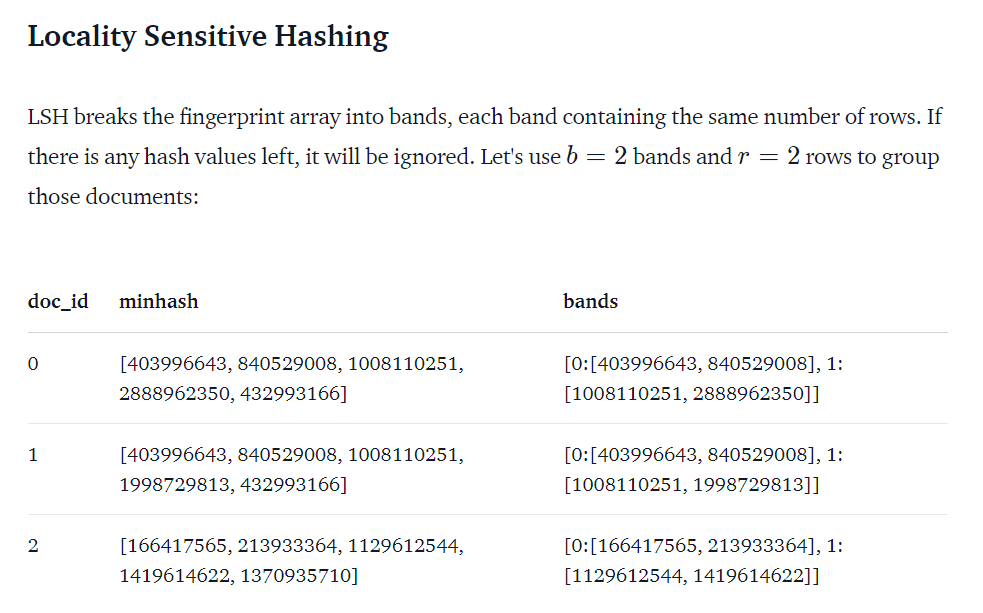

### 2. Step2: gen edges

Once we have the band_index, hash of the band and doc_ids, we need to find which docs are sharing band_index and band_value
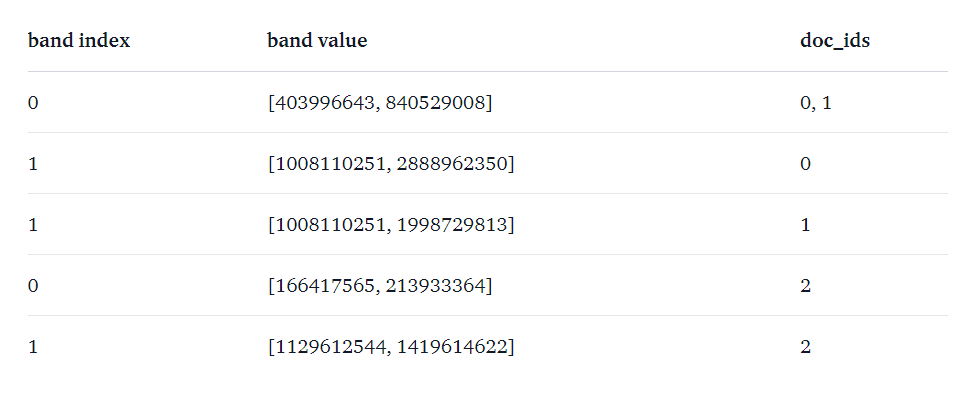